https://www.kesci.com/mw/project/5f3b9309af3980002cbeaa14/content
智能推荐和泛的营销完全不同，后者是将产品卖给客户作为最终目标；而智能推荐是以“客户需求”为导向的，是给客户带来价值的。常见的如淘宝的 “你可能还喜欢”，亚马逊的 “购买此商品的用户也购买了” 便是实例。本项目就将详细介绍如何用Python实现智能推荐算法，主要将分为两个部分：

详细原理介绍
Python代码实战
常见的推荐系统与算法

常见的推荐系统分类有：

基于应用领域: 电子商务/社交好友推荐等

基于设计思想: 基于协同过滤的推荐等

基于使用数据: 基于用户标签的推荐等

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
# %matplotlib inline
# 各种细节配置如 文字大小，图例文字等杂项
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
plt.rc('font', **{'family': 'Microsoft YaHei, SimHei'})  # 设置中文字体的支持
# sns.set(font='SimHei')  # 解决Seaborn中文显示问题，但会自动添加背景灰色网格

plt.rcParams['axes.unicode_minus'] = False
# 解决保存图像是负号'-'显示为方块的问题

"""
数据参数

OrderNumber：客户昵称
LineNumber：购买顺序，如前三行分别表示同一个客户购买的三样商品的顺序
Model：商品名
"""

'\n数据参数\n\nOrderNumber：客户昵称\nLineNumber：购买顺序，如前三行分别表示同一个客户购买的三样商品的顺序\nModel：商品名\n'

In [20]:
df = pd.read_csv(r'E:\MyJPY\Datas\zntj\bike_data.csv', encoding='gbk')
df.info(); df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52761 entries, 0 to 52760
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   OrderNumber  52761 non-null  object
 1   LineNumber   52761 non-null  int64 
 2   Model        52761 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


,OrderNumber,LineNumber,Model
0,cumid51178,1,山地英骑
1,cumid51178,2,山地车水壶架
2,cumid51178,3,运动水壶
3,cumid51184,1,山地英骑
4,cumid51184,2,hl山地外胎


### 探索性数据分析

In [21]:
# 检查重复值
df.duplicated().sum()

0

In [22]:
# 商品种类探索
print(f"数据集中共有{df['Model'].nunique()}种商品")

model_names = df['Model'].unique()
print("商品名分别为：")
# 5 个为一行显示
for i in range(0, len(model_names), 5):
      print(model_names[i:i+5])

数据集中共有37种商品
商品名分别为：
['山地英骑' '山地车水壶架' '运动水壶' 'hl山地外胎' '山地车内胎']
['运动型头盔' '普通公路车' '公路车内胎' 'hl公路外胎' '竞速公路车']
['公路车水壶架' '长袖骑车衣' '山地车挡泥板' '自行车帽' '山地车400']
['ml山地外胎' '修补工具' '山地车500' '公路车550' '短袖经典车衣']
['旅游型自行车(大)' '竞速袜' '半掌手套' '公路车350' 'ml公路外胎']
['水壶包' '旅游型自行车(小)' '旅游型自行车(中)' '旅游车内胎' 'll公路车外胎']
['旅游自行车外胎(通用)' '万能自行车座' '洗车喷剂' '经典背心' 'll山地胎']
['故障栓钩' "Women's Mountain Shorts"]


In [23]:
# 最畅销的 15 种商品
 ## 往 reset_index 中添加 name 参数可快速重命名列名
grouped = df.groupby('Model')['Model'].count().reset_index(name='count')
grouped.head()

,Model,count
0,Women's Mountain Shorts,958
1,hl公路外胎,804
2,hl山地外胎,1331
3,ll公路车外胎,980
4,ll山地胎,799


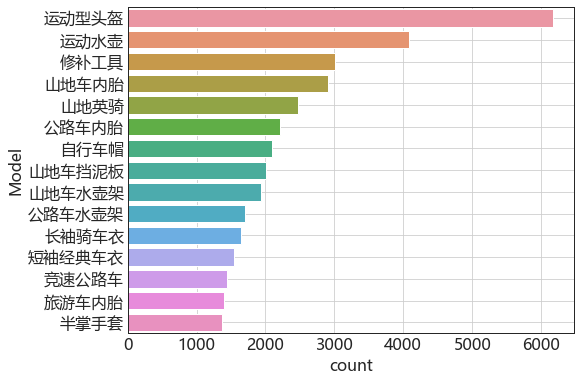

In [24]:
top_15 = grouped.sort_values(by='count', ascending=False).head(15)

plt.figure(figsize=(8, 6))
sns.barplot(data=top_15, x='count', y='Model')
plt.grid(True)

In [25]:
top_15 = top_15['Model'].tolist()
print('初步分析，该自行车店的排名前15的畅销单品为如下：')
for i in range(0, len(top_15), 5):
    print(top_15[i:i+5])

初步分析，该自行车店的排名前15的畅销单品为如下：
['运动型头盔', '运动水壶', '修补工具', '山地车内胎', '山地英骑']
['公路车内胎', '自行车帽', '山地车挡泥板', '山地车水壶架', '公路车水壶架']
['长袖骑车衣', '短袖经典车衣', '竞速公路车', '旅游车内胎', '半掌手套']


### 使用 Apriori 算法求解关联规则
由于有关Apriori等算法的研究已经很成熟，我们在用Python实战时无需一步一步计算，直接调用现有函数即可，主要是要明白背后的原理与不同算法的使用场景与优劣比较。

In [26]:
import Apriori as apri

# 需要稍微等待一下
baskets = apri.dataconvert(arulesdata=df, tidvar='OrderNumber', 
                           itemvar='Model', data_type='inverted')

ModuleNotFoundError: No module named 'Apriori'